In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano
from keras.utils import plot_model
K.clear_session()

np.random.seed(237)

Using TensorFlow backend.


In [0]:
train_orig = pd.read_csv('train.csv')
test_orig = pd.read_csv('test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

In [0]:
# combine original train and test sets
combined = pd.concat([train_orig, test_orig], ignore_index = True)

combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Hold out 5000 random images as a validation/test sample
valid = combined.sample(n = 5000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]
# free up some space and delete test and combined
del train_orig, test_orig, combined

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

image_size = X_train.shape[1]
original_dim = image_size * image_size

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)


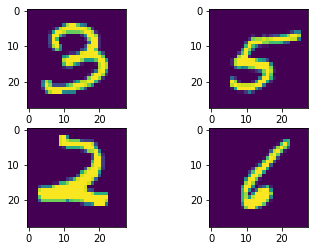

In [0]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[13000][:,:,0])
plt.show()

In [0]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [0]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

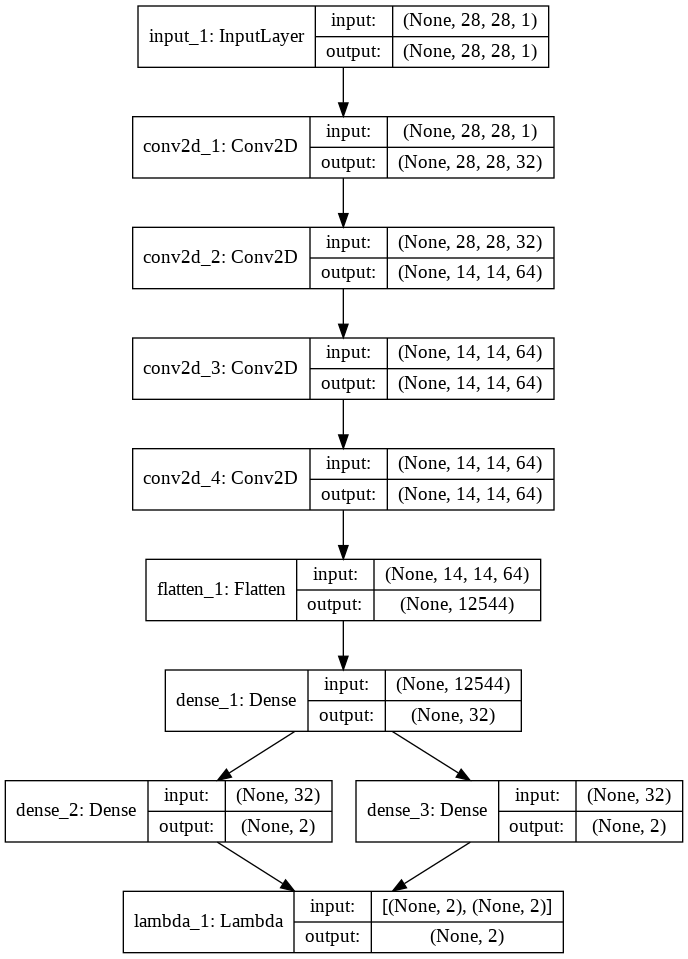

In [0]:
encoder = Model(input_img, [z_mu, z_log_sigma, z], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True)

In [0]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [0]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

In [0]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(X_valid, None))




Train on 65000 samples, validate on 5000 samples
Epoch 1/7





65000/65000 [==============================] - 52s 795us/step - loss: 0.2155 - val_loss: 0.1969
Epoch 2/7
65000/65000 [==============================] - 49s 747us/step - loss: 0.1931 - val_loss: 0.1925
Epoch 3/7
65000/65000 [==============================] - 49s 747us/step - loss: 0.1893 - val_loss: 0.1903
Epoch 4/7
65000/65000 [==============================] - 48s 733us/step - loss: 0.1870 - val_loss: 0.1870
Epoch 5/7
65000/65000 [==============================] - 47s 724us/step - loss: 0.1854 - val_loss: 0.1856
Epoch 6/7
65000/65000 [==============================] - 47s 725us/step - loss: 0.1843 - val_loss: 0.1850
Epoch 7/7
65000/65000 [==============================] - 47s 727us/step - loss: 0.1834 - val_loss: 0.1844


In [0]:
# Isolate original training set records in validation set
train_latent = train[train['label'] != 11]
train_latent19 = train_latent[train_latent['label'] != 0]
# X's and Y's
X_train_latent19 = train_latent19.drop('label', axis=1)
y_train_latent19 = train_latent19['label']

# Reshape and normalize
X_train_latent19 = X_train_latent19.astype('float32') / 255.
X_train_latent19 = X_train_latent19.values.reshape(-1,28,28,1)

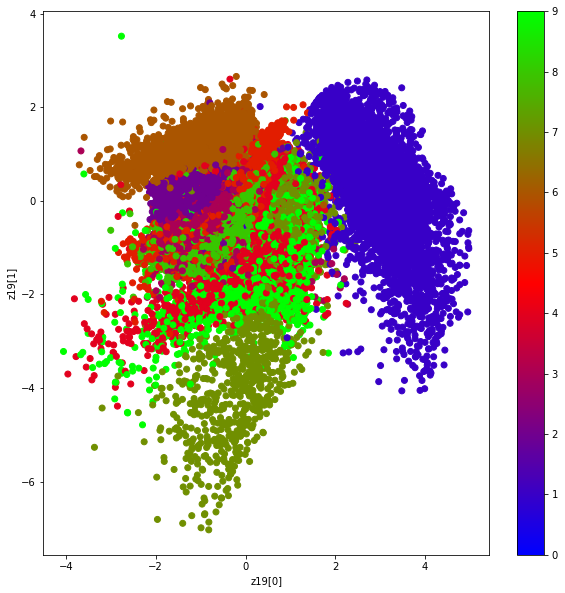

In [0]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
vae_op19 = vae.predict([X_train_latent19])
z19 = encoder.predict(vae_op19)
plt.figure(figsize=(10, 10))
plt.scatter(z19[:, 0], z19[:, 1], c=y_train_latent19, cmap='brg')
plt.clim(0, 9)
plt.xlabel("z19[0]")
plt.ylabel("z19[1]")
plt.colorbar()
plt.show()

In [0]:
# Isolate original training set records in validation set
# X's and Y's
X_train_latent09 = train_latent.drop('label', axis=1)
y_train_latent09 = train_latent['label']

# Reshape and normalize
X_train_latent09 = X_train_latent09.astype('float32') / 255.
X_train_latent09 = X_train_latent09.values.reshape(-1,28,28,1)

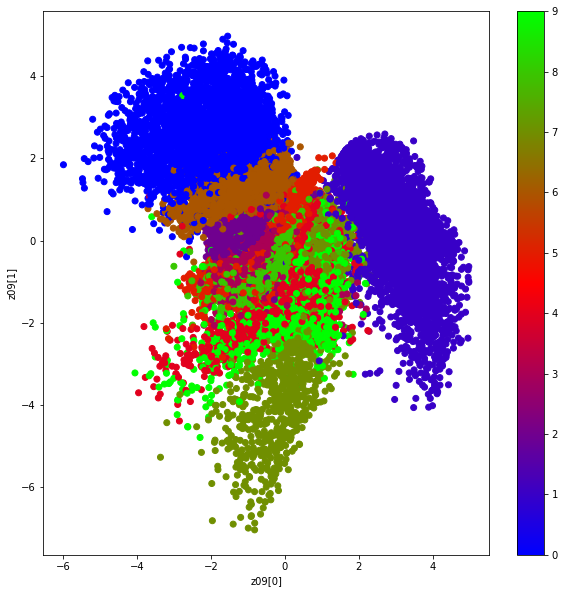

In [0]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
vae_op09 = vae.predict([X_train_latent09])
z09 = encoder.predict(vae_op09)
plt.figure(figsize=(10, 10))
plt.scatter(z09[:, 0], z09[:, 1], c=y_train_latent09, cmap='brg')
plt.clim(0, 9)
plt.xlabel("z09[0]")
plt.ylabel("z09[1]")
plt.colorbar()
plt.show()

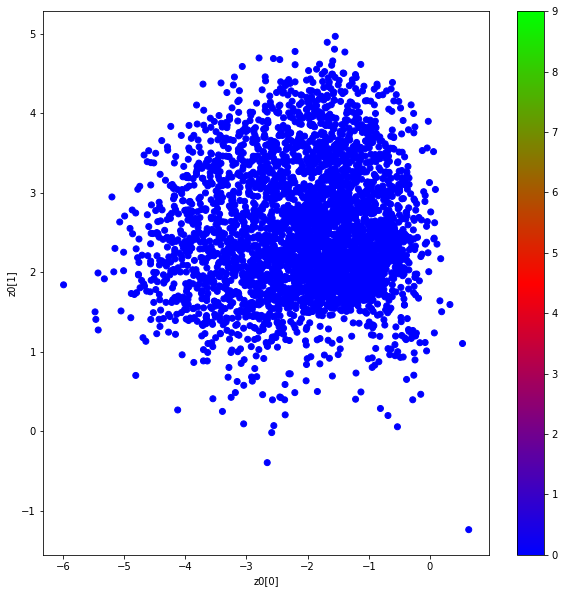

In [0]:
train_latent0 = train[train['label'] == 0]
y_train_latent0 = train_latent0['label']
y_train_latent0 = y_train_latent0[:-1]
mask = np.isin(z09, z19)
idx = np.where(mask)
z0 = np.delete(z09, idx, axis=0)
#z0 = z0[:-1]
plt.figure(figsize=(10, 10))
plt.scatter(z0[:, 0], z0[:, 1], c=y_train_latent0, cmap='brg')
plt.clim(0, 9)
plt.xlabel("z0[0]")
plt.ylabel("z0[1]")
plt.colorbar()
plt.show()

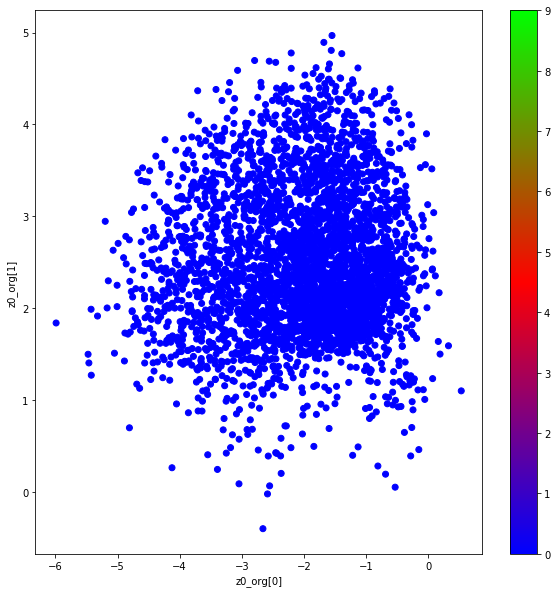

In [0]:
train_latent = train[train['label'] != 11]
train_latent0_org = train_latent[train_latent['label'] == 0]
# X's and Y's
X_train_latent0_org = train_latent0_org.drop('label', axis=1)
y_train_latent0_org = train_latent0_org['label']

# Reshape and normalize
X_train_latent0_org = X_train_latent0_org.astype('float32') / 255.
X_train_latent0_org = X_train_latent0_org.values.reshape(-1,28,28,1)

encoder = Model(input_img, z_mu)
vae_op0_org = vae.predict([X_train_latent0_org])
z0_org = encoder.predict(vae_op0_org)
plt.figure(figsize=(10, 10))
plt.scatter(z0_org[:, 0], z0_org[:, 1], c=y_train_latent0_org, cmap='brg')
plt.clim(0, 9)
plt.xlabel("z0_org[0]")
plt.ylabel("z0_org[1]")
plt.colorbar()
plt.show()

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def norm_dist(z):
  x = z[:, 0]
  y = z[:, 1]
  X, Y = np.meshgrid(x, y)
  pos = np.empty(X.shape + (2,))
  pos[:, :, 0] = X
  pos[:, :, 1] = Y
  rv = multivariate_normal([0.0, 1.0], [[1.0, -0.5], [-0.5, 1.5]])
  Z = rv.pdf(pos)
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                  cmap=cm.viridis)
  cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)
  ax.set_zlim(-0.15,0.2)
  ax.set_zticks(np.linspace(0,0.2,5))
  ax.view_init(27, -21)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')
  plt.show()

In [0]:
#dist0 = z0[:-1500]
#norm_dist(dist0)

In [0]:
#dist0_org = z0_org[:-1500]
#norm_dist(dist0_org)

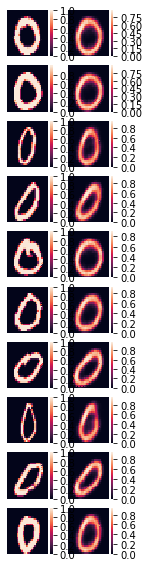

In [0]:
import seaborn as sns
fig, axes = plt.subplots(10, 2, figsize=(2, 10))
n = len(X_train_latent0_org)
index = np.random.randint(n, size=100)
#vae_op = vae.predict([X_train_latent0_org[index]])
#x_encoded = encoder.predict(vae_op)
x_decoded = decoder.predict(z0_org, batch_size=batch_size)
      
for i in range(10):
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    plt.sca(axes[i, 0])
    sns.heatmap(X_train_latent0_org[i].reshape(28, 28))
    axes[i, 1].get_xaxis().set_visible(False)
    axes[i, 1].get_yaxis().set_visible(False)
    plt.sca(axes[i, 1])
    sns.heatmap(x_decoded[i].reshape(28, 28))

plt.show()

In [0]:
from PIL import Image as Img
from PIL import ImageTk
from PIL import ImageChops
d = (28*28) / 255
from skimage import measure
for i in range(100):
  image1 = X_train_latent0_org[index[i]]
  image2 = x_decoded[i]
  pixel_sim_err = np.sum(np.absolute(image1 - image2)) / d
  pixel_sim_err += pixel_sim_err


avg_pixel_sim_err= pixel_sim_err/100

avg_pixel_sim_err

0.955269212138896

In [0]:
for i in range(100):
  image1 = X_train_latent0_org[index[i]]
  image2 = x_decoded[i]
  ssim_err = measure.compare_ssim(image1, image2, multichannel="True")
  ssim_err += ssim_err

avg_ssim_err= ssim_err/100
avg_ssim_err

0.005983875203074422

In [0]:

import plotly.graph_objects as go
Errors=['Avg Pixel Sim Error', 'Avg SSIM Error']
fig = go.Figure([go.Bar(x=Errors, y=[avg_pixel_sim_err, avg_ssim_err], width=[0.2, 0.2])])
fig.show()